In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load data
orders = pd.read_csv('../data/raw/olist_orders_dataset.csv')
order_items = pd.read_csv('../data/raw/olist_order_items_dataset.csv')

# Convert dates
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

print("Data loaded!")

Data loaded!


In [2]:
# Combine orders with prices
customer_orders = orders.merge(order_items, on='order_id')

# What's the last date in our data?
max_date = customer_orders['order_purchase_timestamp'].max()
print(f"Latest order date: {max_date}")

# For each customer, calculate:
# 1. Recency: Days since their last purchase
# 2. Frequency: How many orders they made
# 3. Monetary: Total amount they spent

rfm = customer_orders.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,  # Recency
    'order_id': 'nunique',  # Frequency (count unique orders)
    'price': 'sum'  # Monetary (total spent)
})

# Rename columns to make sense
rfm.columns = ['recency', 'frequency', 'monetary']

print("\nRFM Table:")
print(rfm.head(10))

Latest order date: 2018-09-03 09:06:57

RFM Table:
                                  recency  frequency  monetary
customer_id                                                   
00012a2ce6f8dcda20d059ce98491703      292          1     89.80
000161a058600d5901f007fab4c27140      413          1     54.90
0001fd6190edaaf884bcaf3d49edf079      551          1    179.99
0002414f95344307404f0ace7a26f1d5      382          1    149.90
000379cdec625522490c315e70c7a9fb      153          1     93.00
0004164d20a9e969af783496f3408652      509          1     59.99
000419c5494106c306a97b5635748086      184          1     34.30
00046a560d407e99b969756e0b10f282      258          1    120.90
00050bf6e01e69d5c0fd612f1bcfb69c      350          1     69.99
000598caf2ef4117407665ac33275130       22          1   1107.00


RFM Statistics:
            recency  frequency      monetary
count  98666.000000    98666.0  98666.000000
mean     244.815803        1.0    137.754076
std      153.392909        0.0    210.645145
min        0.000000        1.0      0.850000
25%      121.000000        1.0     45.900000
50%      226.000000        1.0     86.900000
75%      355.000000        1.0    149.900000
max      728.000000        1.0  13440.000000


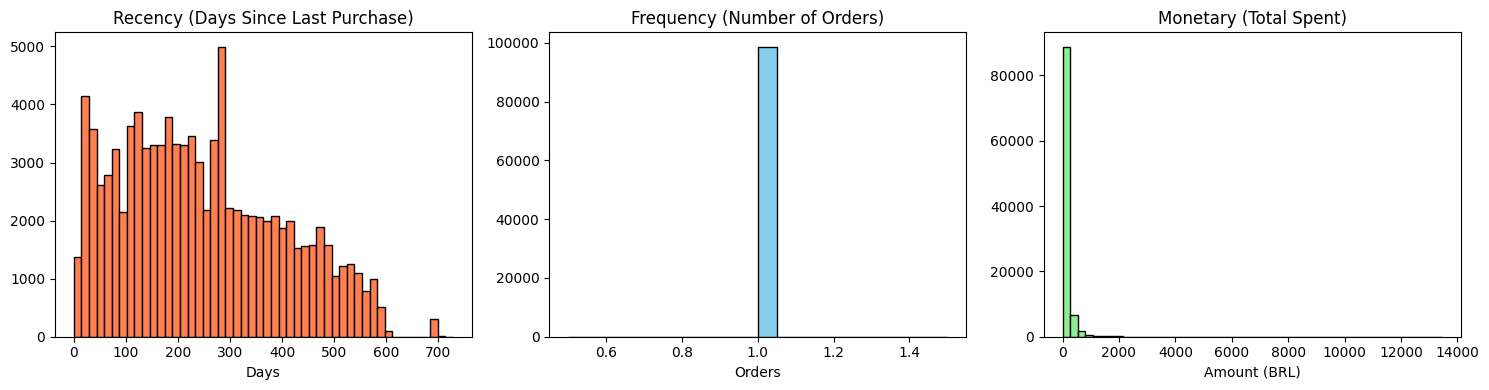

In [3]:
# Let's look at the distribution
print("RFM Statistics:")
print(rfm.describe())

# Make histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(rfm['recency'], bins=50, color='coral', edgecolor='black')
axes[0].set_title('Recency (Days Since Last Purchase)')
axes[0].set_xlabel('Days')

axes[1].hist(rfm['frequency'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('Frequency (Number of Orders)')
axes[1].set_xlabel('Orders')

axes[2].hist(rfm['monetary'], bins=50, color='lightgreen', edgecolor='black')
axes[2].set_title('Monetary (Total Spent)')
axes[2].set_xlabel('Amount (BRL)')

plt.tight_layout()
plt.show()

In [4]:
# We'll score each customer on a scale of 1-4 for each metric
# For Recency: Lower days = Better score (bought recently = good)
# For Frequency: More orders = Better score
# For Monetary: More spent = Better score

# Create Recency score (1-4, where 4 is best = most recent)
rfm['R_score'] = pd.qcut(rfm['recency'], q=4, labels=[4, 3, 2, 1])

# Create Frequency score (1-4, where 4 is best = most frequent)
# We use 'rank' here because many customers have the same frequency
rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])

# Create Monetary score (1-4, where 4 is best = highest spending)
rfm['M_score'] = pd.qcut(rfm['monetary'], q=4, labels=[1, 2, 3, 4])

print("RFM with Scores:")
print(rfm.head(10))

RFM with Scores:
                                  recency  frequency  monetary R_score   
customer_id                                                              
00012a2ce6f8dcda20d059ce98491703      292          1     89.80       2  \
000161a058600d5901f007fab4c27140      413          1     54.90       1   
0001fd6190edaaf884bcaf3d49edf079      551          1    179.99       1   
0002414f95344307404f0ace7a26f1d5      382          1    149.90       1   
000379cdec625522490c315e70c7a9fb      153          1     93.00       3   
0004164d20a9e969af783496f3408652      509          1     59.99       1   
000419c5494106c306a97b5635748086      184          1     34.30       3   
00046a560d407e99b969756e0b10f282      258          1    120.90       2   
00050bf6e01e69d5c0fd612f1bcfb69c      350          1     69.99       2   
000598caf2ef4117407665ac33275130       22          1   1107.00       4   

                                 F_score M_score  
customer_id                                

In [5]:
# Combine the three scores into one string like "444" or "231"
rfm['RFM_score'] = (rfm['R_score'].astype(str) + 
                    rfm['F_score'].astype(str) + 
                    rfm['M_score'].astype(str))

print("Sample RFM Scores:")
print(rfm['RFM_score'].head(20))

# Count how many customers have each score
print("\nTop 10 most common scores:")
print(rfm['RFM_score'].value_counts().head(10))

Sample RFM Scores:
customer_id
00012a2ce6f8dcda20d059ce98491703    213
000161a058600d5901f007fab4c27140    112
0001fd6190edaaf884bcaf3d49edf079    114
0002414f95344307404f0ace7a26f1d5    113
000379cdec625522490c315e70c7a9fb    313
0004164d20a9e969af783496f3408652    112
000419c5494106c306a97b5635748086    311
00046a560d407e99b969756e0b10f282    213
00050bf6e01e69d5c0fd612f1bcfb69c    212
000598caf2ef4117407665ac33275130    414
0005aefbb696d34b3424dccd0a0e9fd0    413
00062b33cb9f6fe976afdcff967ea74d    112
00066ccbe787a588c52bd5ff404590e3    314
00072d033fe2e59061ae5c3aff1a2be5    113
0009a69b72033b2d0ec8c69fc70ef768    114
000bf8121c3412d3057d32371c5d3395    211
000e943451fc2788ca6ac98a682f2f49    113
000f17e290c26b28549908a04cfe36c1    213
000fd45d6fedae68fc6676036610f879    312
0010068a73b7c56da5758c3f9e5c7375    111
Name: RFM_score, dtype: object

Top 10 most common scores:
RFM_score
343    1659
423    1618
242    1614
141    1610
131    1603
333    1603
224    1600
222    1599
311 

In [6]:
# Now let's group these scores into meaningful segments
def segment_customer(row):
    """
    This function takes an RFM score and returns a segment name.
    We look at the score and decide which group they belong to.
    """
    score = row['RFM_score']
    r = int(score[0])  # First digit is Recency
    f = int(score[1])  # Second digit is Frequency
    m = int(score[2])  # Third digit is Monetary
    
    # Champions: Best customers (high on everything)
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    
    # Loyal: Buy frequently
    elif f >= 4:
        return 'Loyal Customers'
    
    # Big Spenders: Spend a lot but not frequently
    elif m >= 4:
        return 'Big Spenders'
    
    # At Risk: Used to be good but haven't bought recently
    elif r <= 2 and f >= 3:
        return 'At Risk'
    
    # Lost: Haven't bought in a long time
    elif r <= 2:
        return 'Lost'
    
    # New Customers: Recent but not frequent
    elif r >= 3 and f <= 2:
        return 'New Customers'
    
    # Everyone else
    else:
        return 'Regular'

# Apply the function to every customer
rfm['segment'] = rfm.apply(segment_customer, axis=1)

print("Customer Segments:")
print(rfm['segment'].value_counts())

Customer Segments:
segment
Loyal Customers    23114
New Customers      18688
Lost               18395
Big Spenders       18393
Regular             9266
At Risk             9257
Champions           1553
Name: count, dtype: int64


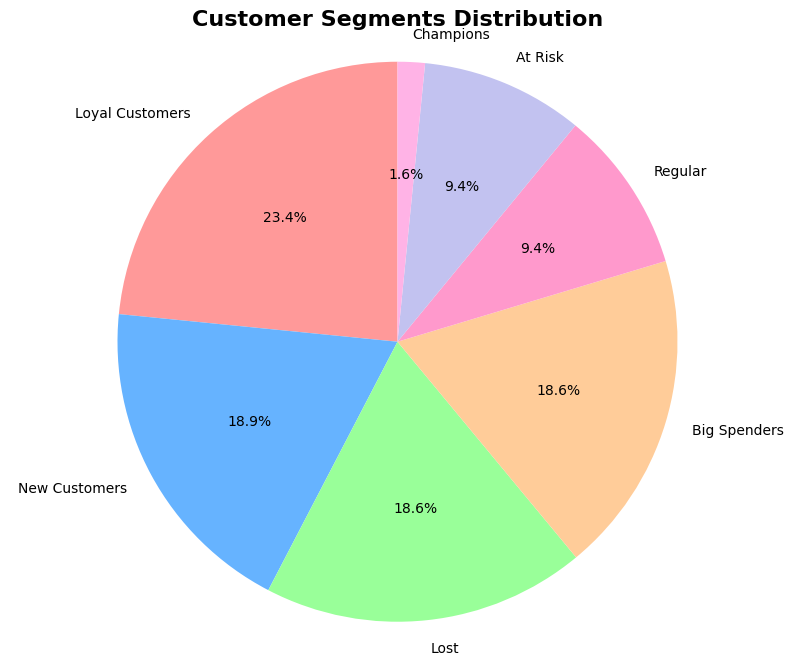


Segment Statistics:
                 recency  frequency  monetary  customer_count
segment                                                      
At Risk           373.27        1.0     68.64            9257
Big Spenders      246.35        1.0    343.39           18393
Champions          63.77        1.0    374.34            1553
Lost              371.14        1.0     68.25           18395
Loyal Customers   257.00        1.0    123.44           23114
New Customers     117.99        1.0     69.69           18688
Regular           118.40        1.0     69.94            9266


In [7]:
# Count customers in each segment
segment_counts = rfm['segment'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0', '#ffb3e6']
plt.pie(segment_counts.values, 
        labels=segment_counts.index, 
        autopct='%1.1f%%',
        colors=colors,
        startangle=90)
plt.title('Customer Segments Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

# Show detailed stats for each segment
print("\nSegment Statistics:")
segment_stats = rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)

segment_stats['customer_count'] = rfm.groupby('segment').size()
print(segment_stats)

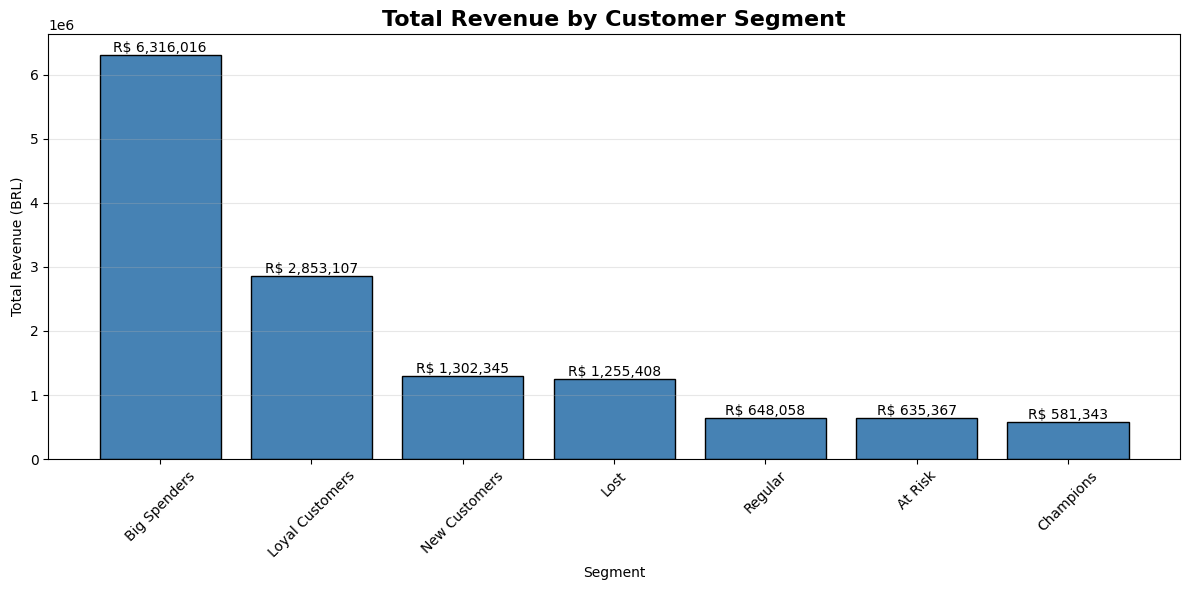


Revenue Percentage by Segment:
segment
Big Spenders       46.5
Loyal Customers    21.0
New Customers       9.6
Lost                9.2
Regular             4.8
At Risk             4.7
Champions           4.3
Name: monetary, dtype: float64


In [8]:
# Calculate revenue by segment
segment_revenue = rfm.groupby('segment')['monetary'].sum().sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(segment_revenue.index, segment_revenue.values, color='steelblue', edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'R$ {height:,.0f}',
             ha='center', va='bottom', fontsize=10)

plt.title('Total Revenue by Customer Segment', fontsize=16, fontweight='bold')
plt.xlabel('Segment')
plt.ylabel('Total Revenue (BRL)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# What percentage of revenue comes from each segment?
segment_revenue_pct = (segment_revenue / segment_revenue.sum() * 100).round(1)
print("\nRevenue Percentage by Segment:")
print(segment_revenue_pct)

In [9]:
# Save the RFM data so we can use it later
rfm.to_csv('../data/processed/customer_rfm.csv')
print("RFM data saved to data/processed/customer_rfm.csv")

RFM data saved to data/processed/customer_rfm.csv
